## Convex Optimization using CVXPY

CVXPY is a Python-embedded language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

### install:
I used "pip install cvxpy". Otherwise, look at:
https://www.cvxpy.org/install/index.html




The code below solves a simple optimization problem in CVXPY:


In [1]:


import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create two scalar optimization variables.
x = cvx.Variable()
y = cvx.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cvx.Minimize((x - y)**2)

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


prob.solve() returns the optimal value and updates prob.status, prob.value, and the value field of all the variables in the problem.



Problems are immutable, meaning they cannot be changed after they are created. To change the objective or constraints, create a new problem.



In [3]:
# Replace the objective.
prob2 = cvx.Problem(cvx.Maximize(x + y), prob.constraints)
print("optimal value", prob2.solve())

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob.constraints[1:]
prob2 = cvx.Problem(prob.objective, constraints)
print("optimal value", prob2.solve())

optimal value 0.9999999999945574
optimal value 1.0


When a problem has no feasible solutions, meaning the set of solutions 
that satisfy the constraints is empty, we say that the 
probelm is "infeasible".


In [4]:
x = cvx.Variable()

# An infeasible problem.
prob = cvx.Problem(cvx.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: infeasible
optimal value inf


When a problem has no lower bound, meaning the objective function
can achieve arbitrary low values (or negative infinity) we say that the problem is "unbounded".

In [5]:
# An unbounded problem.
prob = cvx.Problem(cvx.Minimize(x))
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: unbounded
optimal value -inf


Notice that for a minimization problem the optimal value is inf if infeasible and -inf if unbounded. For maximization problems the opposite is true.



## Vectors and matrices
Variables can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.



In [6]:
# A scalar variable.
a = cvx.Variable()

# Vector variable with shape (5,).
x = cvx.Variable(5)

# Matrix variable with shape (5, 1).
x = cvx.Variable((5, 1))

# Matrix variable with shape (4, 7).
A = cvx.Variable((4, 7))

Here’s an example of a CVXPY problem with vectors and matrices:



In [7]:
# Solves a bounded least-squares problem.
# Problem data.
m = 10
n = 5
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cvx.Variable(n)
objective = cvx.Minimize(cvx.sum_squares(A@x - b))
constraints = [0 <= x, x <= 1]
prob = cvx.Problem(objective, constraints)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

Optimal value 4.141338603672535
Optimal var
[-4.95922264e-21  6.07571976e-21  1.34643668e-01  1.24976681e-01
 -4.57130806e-21]


## Constraints
As shown in the example code, you can use ==, <=, and >= to construct constraints in CVXPY. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints 0 <= x and x <= 1 mean that every entry of x is between 0 and 1.

You cannot construct inequalities with < and >. Strict inequalities don’t make sense in a real world setting. Also, you cannot chain constraints together, e.g., 0 <= x <= 1 or x == y == 2. The Python interpreter treats chained constraints in such a way that CVXPY cannot capture them. CVXPY will raise an exception if you write a chained constraint.

## Parameters

Parameters are symbolic representations of constants. The purpose of parameters is to change the value of a constant in a problem without reconstructing the entire problem.




In [8]:
# Positive scalar parameter.
m = cvx.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cvx.Parameter(5)

# Matrix parameter with negative entries.
G = cvx.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -np.ones((4, 7))

You can initialize a parameter with a value. The following code segments are equivalent:



In [9]:
# Create parameter, then assign value.
rho = cvx.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cvx.Parameter(nonneg=True, value=2)

## Excercise - The lasso regularization path
For $ A\in \mathbb{R}^{m,n}, x\in \mathbb{R}^n, b\in \mathbb{R}^m$,
code and solve the following:

\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}}
& & ||Ax-b||_2^2 + \gamma ||x||_1 \\
& \text{subject to}
& & \gamma \geq 0 \\
\end{aligned}
\end{equation*}


In [10]:
#generate random input

n = 15
m = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem, use cvx.norm(x,1) for ||x||_1
x = cvx.Variable(n)
gamma = cvx.Parameter(nonneg=True)
error = cvx.sum_squares(A @ x - b)
objective = cvx.Minimize(error + gamma * cvx.norm(x,1))

constraints = [x >= -n, x <= n]
prob = cvx.Problem(objective, constraints)

gamma_vals = np.logspace(-4, 6)  

for val in gamma_vals:
    gamma.value = val
    
#call solve() and print output
print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

Optimal value 27.13505396566872
Optimal var
[-3.09942003e-24  4.71377100e-24  7.70686404e-23 -3.44407069e-23
 -1.21617163e-23  7.22555479e-23  7.53895810e-24 -3.48842804e-23
  8.99613318e-24  1.52751590e-23  4.92718172e-23 -3.54056890e-23
 -5.18436392e-24 -4.50240897e-23 -5.21546904e-23]


The next segment will graph a trade-off curve of ||Ax-B||_2^2 against ||x||_1, where x stands for the optimal solution for a given gamma.
We'll draw the curve by solving for different
gamma values, and then take the solver solution's values for 
||Ax-B||_2^2 and ||x||_1.

    Question: Why plot axis is against ||x||_1 and not \gamma*||x||_1 as in the objective?    

Gamma - is a parameter which punish x for being a large vector (with respect to l1 norm). As we try to find optimum minimum, we have to minimize the loss function and this is depend on x

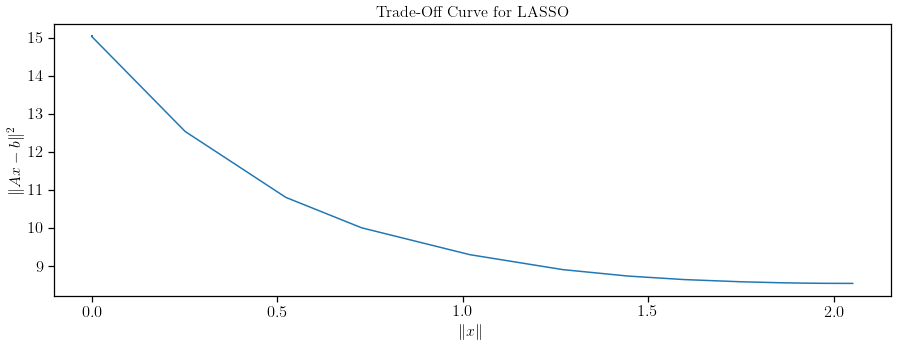

In [11]:
# Problem data.
n = 15
m = 10
np.random.seed(1)
A = np.random.randn(n, m)
b = np.random.randn(n)

# Construct the problem, use cvx.norm(x,1) for ||x||_1
# gamma must be nonnegative due to DCP rules.
gamma = cvx.Parameter(nonneg=True)
x = cvx.Variable(m)
error = cvx.sum_squares(A @ x - b)
obj = cvx.Minimize(error + gamma*cvx.norm(x, 1))
prob = cvx.Problem(obj)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []

gamma_vals = np.logspace(-4, 6)

for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cvx.norm(x, 1).value)
    x_values.append(x.value)
    
# Plot trade-off curve.

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(15,5))
plt.plot(l1_penalty, sq_penalty)
plt.xlabel(r'$\|x\|$', fontsize=16)
plt.ylabel(r'$\|Ax-b\|^2$', fontsize=16)
plt.title('Trade-Off Curve for LASSO', fontsize=16);

Repeat the previous excercise, but now plot the regularization path: 
    for each gamma, we overlay (x_i), i'th entry of the optimal
    solution x. 

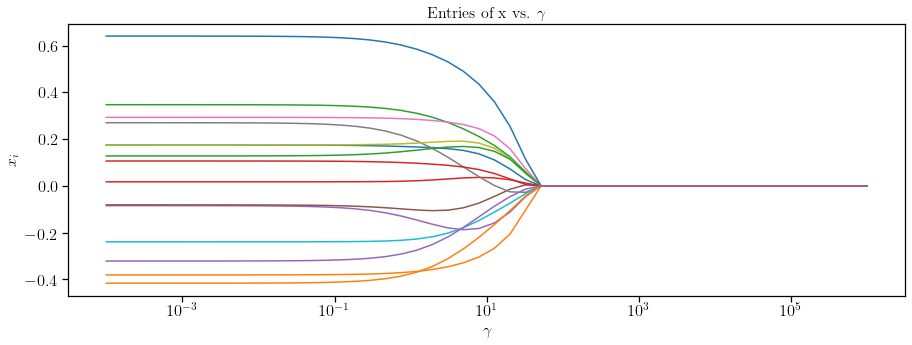

In [12]:
n = 15
m = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)


# Construct the problem as before, 
# but now gamma must be nonnegative parameter.
x = cvx.Variable(n)
gamma = cvx.Parameter(nonneg=True)
error = cvx.sum_squares(A @ x - b)
objective = cvx.Minimize(error+gamma * cvx.norm(x))
constraints = [x >= -n, x <= n]
prob = cvx.Problem(objective, constraints)

gamma_vals = np.logspace(-4, 6)
x_values = []
for val in gamma_vals:
        gamma.value = val
        prob.solve()
        x_values.append(x.value)
        
        
#Plot entries of x vs. gamma.
plt.figure(figsize=(15,5))

for i in range(n):#replace ... with your optimal solutions list
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.plot(gamma_vals, [xi[i] for xi in x_values])
    plt.xscale('log')
    plt.xlabel('$\gamma$', fontsize=16)
    plt.ylabel('$x_{i}$', fontsize=16)
    plt.xscale('log')
    plt.title('Entries of x vs.  $\gamma$', fontsize=16);
